In [1]:
import time
import json
import random
import numpy as np
from qiskit import *
from qiskit import Aer
import tensorflow as tf
from qiskit import IBMQ
import matplotlib.pyplot as plt
from qiskit.circuit import Reset
from IPython.display import display
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.random import random_circuit
from qiskit.circuit.exceptions import CircuitError
from sympy.utilities.iterables import multiset_permutations
from qiskit.visualization import plot_histogram, plot_circuit_layout
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit

from qiskit.circuit.library.standard_gates import (
    IGate,
    U1Gate,
    U2Gate,
    U3Gate,
    XGate,
    YGate,
    ZGate,
    HGate,
    SGate,
    SdgGate,
    TGate,
    TdgGate,
    RXGate,
    RYGate,
    RZGate,
    CXGate,
    CYGate,
    CZGate,
    CHGate,
    CRZGate,
    CU1Gate,
    CU3Gate,
    SwapGate,
    RZZGate,
    CCXGate,
    CSwapGate,
)

In [2]:
IBMQ.save_account('de404b7eba21afacf3e900bcd1cc1244967cecad8f7051683e08ff88d444aee2e6cb029f51036d2eb8efd6f18bd04acf5d9bc0891891ebe4c1bb1ab062f7741b', overwrite=True)
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
def random_circuit(num_qubits, depth, max_operands=2, measure=False, conditional=False, reset=False, seed=None):
    """Generate random circuit of arbitrary size and form.

    Args:
        num_qubits (int): number of quantum wires
        depth (int): layers of operations (i.e. critical path length)
        max_operands (int): maximum operands of each gate (between 1 and 3)
        measure (bool): if True, measure all qubits at the end
        conditional (bool): if True, insert middle measurements and conditionals
        reset (bool): if True, insert middle resets
        seed (int): sets random seed (optional)
        
    """
    if max_operands < 1 or max_operands > 3:
        raise CircuitError("max_operands must be between 1 and 3")

    one_q_ops = []
    one_param = []
    two_param = []
    three_param = []
    two_q_ops = [CXGate]
    three_q_ops = []

    qr = QuantumRegister(num_qubits, "q")
    qc = QuantumCircuit(num_qubits)

    if measure or conditional:
        cr = ClassicalRegister(num_qubits, "c")
        qc.add_register(cr)

    if reset:
        one_q_ops += [Reset]

    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng = np.random.default_rng(seed)

    # apply arbitrary random operations at every depth
    for _ in range(depth):
        # choose either 1, 2, or 3 qubits for the operation
        remaining_qubits = list(range(num_qubits))
        rng.shuffle(remaining_qubits)
        while remaining_qubits:
            max_possible_operands = min(len(remaining_qubits), max_operands)
            num_operands = rng.choice(range(max_possible_operands)) + 1
            operands = [remaining_qubits.pop() for _ in range(num_operands)]
            
            if num_operands == 1:
                continue
            elif num_operands == 2:
                operation = CXGate
            elif num_operands == 3:
                continue
                
            num_angles = 0
            angles = [rng.uniform(0, 2 * np.pi) for x in range(num_angles)]
            register_operands = [qr[i] for i in operands]
            op = operation(*angles)

            # with some low probability, condition on classical bit values
            if conditional and rng.choice(range(10)) == 0:
                value = rng.integers(0, np.power(2, num_qubits))
                op.condition = (cr, value)

            qc.append(op, register_operands)

    if measure:
        qc.measure(qr, cr)

    return qc

In [4]:
def allgates(qc, transpiled_circuit):
    count = transpiled_circuit.count_ops()
    items = list(count.items())
    pieces = len(items)
    new_arrays = np.array_split(items, pieces)
    new_arrays
    for i in range(pieces):
        if(new_arrays[i][0][0] == 'cx'):
            cnotcount = int(new_arrays[i][0][1])

    return cnotcount

def gatecount(qc, layout, backend, plot=0):
    transpiled_circuit = transpile(qc, backend, initial_layout=layout)
    cx = allgates(qc, transpiled_circuit)
    
    return cx

In [5]:
def getfeatures(qc):
    gatedata = []
    for gate in qc.data:
        if (gate[0].name == 'cx'):
            gatedata.append(gate[1])
    gatedata = np.array(gatedata)
    l = np.shape(gatedata)[0]

    cnotarray = np.zeros([l,2], dtype=int)
    for i in range(l):
        cnotarray[i][0] = gatedata[i][0].index
        cnotarray[i][1] = gatedata[i][1].index
    return cnotarray.flatten()

def getqiskitlayout(qc, backend, plot = 0):
    transpiled_circuit = transpile(qc, backend, optimization_level=3) 
    bits = transpiled_circuit._layout.get_physical_bits()
    
    if(plot==1):
        fig = plot_circuit_layout(transpiled_circuit, backend)
        display(fig)

    qiskitlayout = []
    for i in range(len(bits)):
        regtype = transpiled_circuit._layout.get_physical_bits()[i].register.qasm()
        if(regtype.find('ancilla')==-1):
            qiskitlayout.append(transpiled_circuit._layout.get_physical_bits()[i].index)
        else:   
            qiskitlayout.append(-1)
            
    return np.array(qiskitlayout)

In [6]:
def elementgen(qubitno, depth, backend, plot=0):
    qc = random_circuit(num_qubits=qubitno, depth=depth)
    if(plot == 1):
        fig = qc.draw(output='mpl')
        display(fig)
        
    x = getfeatures(qc)
    y = getqiskitlayout(qc, backend, plot)
    
    return x, y

def datagen(size, qubitno, backend):
    train = []
    target = []
    for i in range(size):
        x, y = elementgen(qubitno=qubitno, depth=random.randint(1,14), backend=backend, plot=0)
        train.append(x)
        target.append(y)
        if(i%1000 == 0):
            print("Iteration", i)

    return train, target

In [7]:
def get_key(val, dictionary):
    for key, value in dictionary.items():
        if (np.array_equal(val, value)):
            return key
    return "Key doesn't exist"

def targetdatagen(targetraw, layoutdict):
    y = []
    for i in range(datasetsize):
        index = get_key(targetraw[i], layoutdict)
        output = onehotdict[index]
        y.append(output)
    
    return y

In [8]:
my_provider = IBMQ.get_provider()
backend  = my_provider.get_backend('ibmq_lima')

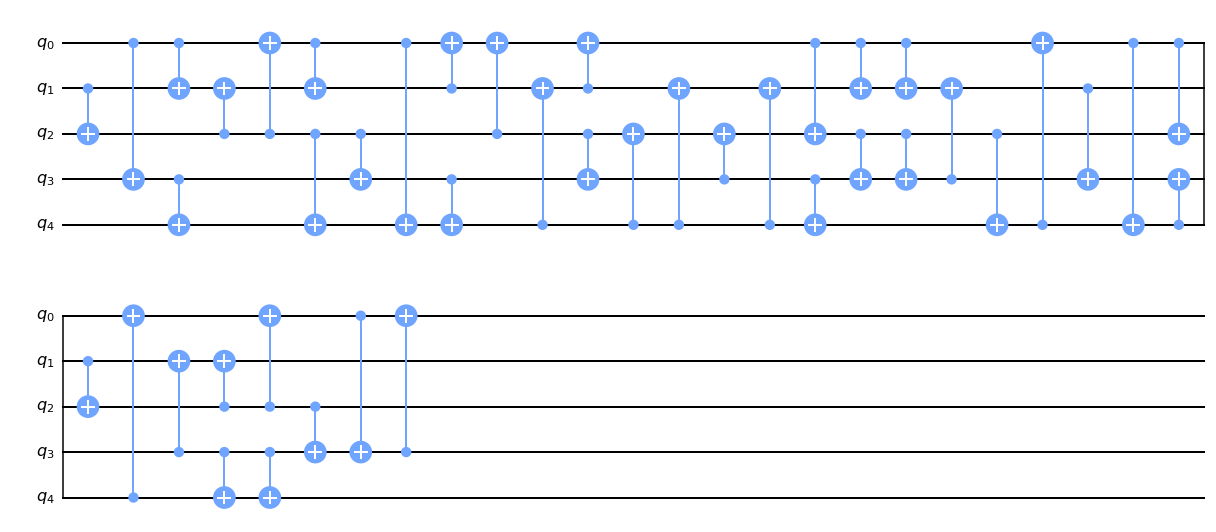

C:\Users\aniru\AppData\Local\Temp/ipykernel_47900/2832588031.py:11: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  cnotarray[i][0] = gatedata[i][0].index
C:\Users\aniru\AppData\Local\Temp/ipykernel_47900/2832588031.py:12: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  cnotarray[i][1] = gatedata[i][1].index


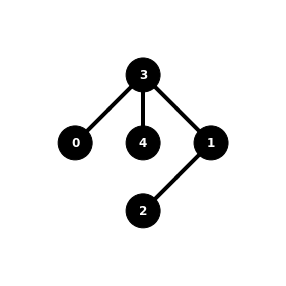

[1 2 0 3 0 1 3 4 2 1 2 0 2 4 2 3 0 1 0 4 1 0 3 4 2 0 2 3 4 1 4 2 1 0 4 1 3
 2 4 1 0 2 0 1 3 4 2 3 0 1 2 3 3 1 2 4 4 0 0 4 1 3 0 2 4 3 1 2 4 0 3 1 3 4
 2 1 2 0 3 4 2 3 0 3 3 0]
[0 3 4 1 2]


C:\Users\aniru\AppData\Local\Temp/ipykernel_47900/2832588031.py:25: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  regtype = transpiled_circuit._layout.get_physical_bits()[i].register.qasm()
C:\Users\aniru\AppData\Local\Temp/ipykernel_47900/2832588031.py:27: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qiskitlayout.append(transpiled_circuit._layout.get_physical_bits()[i].index)


In [9]:
x, y = elementgen(qubitno=5, depth=30, backend=backend, plot=1)
print(x)
print(y)

In [10]:
qubitno = 5
datasetsize = 30000
trainraw, targetraw = datagen(size=datasetsize, qubitno=qubitno, backend=backend)

C:\Users\aniru\AppData\Local\Temp/ipykernel_47900/2832588031.py:11: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  cnotarray[i][0] = gatedata[i][0].index
C:\Users\aniru\AppData\Local\Temp/ipykernel_47900/2832588031.py:12: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  cnotarray[i][1] = gatedata[i][1].index
C:\Users\aniru\AppData\Local\Temp/ipykernel_47900/2832588031.py:25: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  regtype = transpiled_circuit._layout.get_physical_bits()[i].register.qasm()
C:\Users\aniru\AppData\Local\Temp/ipykernel_47900/2832588031.py:27: DeprecationWarning: Back-references to from Bit instances to their 

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000
Iteration 18000
Iteration 19000
Iteration 20000
Iteration 21000
Iteration 22000
Iteration 23000
Iteration 24000
Iteration 25000
Iteration 26000
Iteration 27000
Iteration 28000
Iteration 29000


In [11]:
layouts = np.array([0, 1, 2, 3, 4])
arr = []
for p in multiset_permutations(layouts):
    arr.append(p)
layoutdict = dict(enumerate(arr, 0))

encoded = np.zeros([120,120], dtype = int)
for i in range(120):
    for j in range(120):
        if(i==j):
            encoded[i][j] = 1
onehotdict = dict(enumerate(encoded, 0))

x_data = trainraw
y_data = targetdatagen(targetraw, layoutdict)

max_length = max(len(row) for row in x_data)
x_data = np.array([np.pad(row, (0, max_length-len(row))) for row in x_data])

In [12]:
np.savetxt('x_data0.txt', x_data, fmt='%d')
np.savetxt('y_data0.txt', y_data, fmt='%d')